# library importing

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import sklearn
import random
from unicodedata import normalize
from keras.layers import Dense
from keras import Input
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 예시로 하나 해보기

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

wav, sr = librosa.load('/content/drive/MyDrive/test/custom.wav', sr=16000)

In [ ]:
# sampling rate는 1초에 몇개의 샘플을 뽑아내느냐이다.
# 소리라는 아날로그 정보를 디지털로 표현하기 위해 시간을 아주 잘게 쪼개서 기록하는데, 이 때 1초에 몇개를 기록하느냐가 sr이다.
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (614059,)
length: 38.3786875 secs


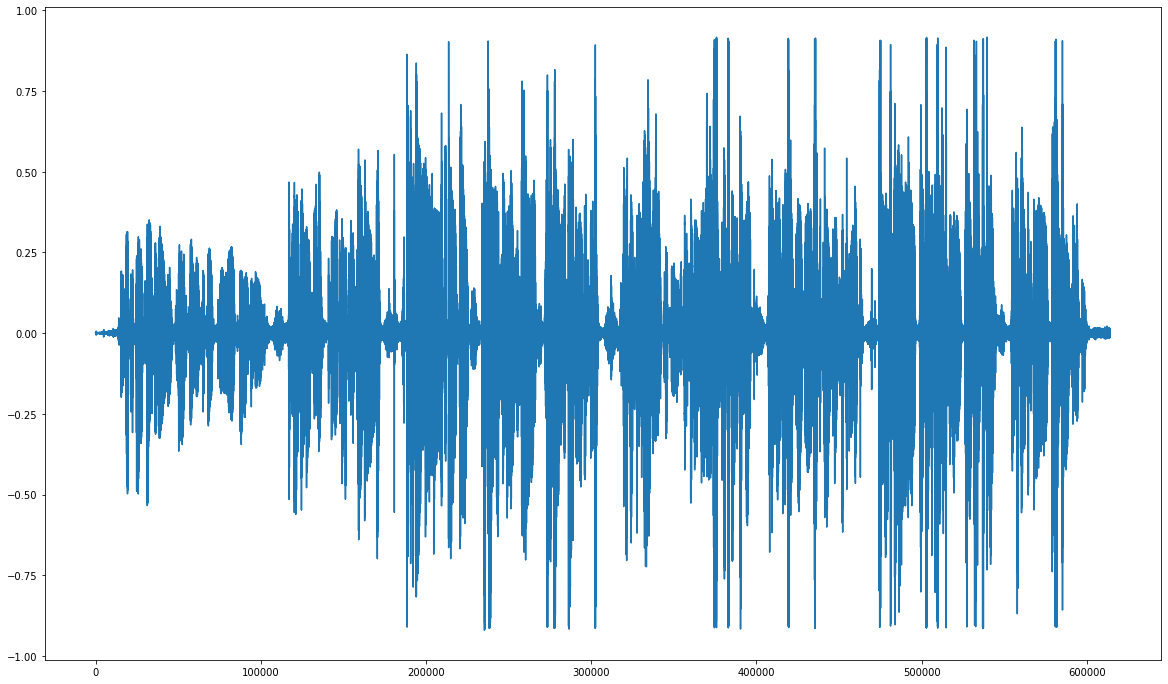

In [ ]:
# 파형보기
plt.figure(figsize=(20,12))
plt.plot(wav)

In [ ]:
# 일반적으로 자연어 처리에서 window size는 25ms 이다. 16000x0.025 면 한 윈도우당 400개의 샘플
# hop_length는 얼마나 이동하는지를 나타냄. 보통 10ms으로 한다. 그래서 16000x0.01=160으로 160개의 샘플씩 이동
mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)

# 뽑아낸 벡터들을 스케일링 한다.
mfcc = scaler.fit_transform(mfcc)

# padding 하기
# 얜 mfcc에 대해 padding을 하겠다는 건데 의미없는 함수..
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
# mfcc가 100이므로 (100, x) 가 된다. 우리가 지정한 i보다 x가 크면 i까지만 자르고 작으면 0으로 뒷 부분을 채워준다.
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

mfcc가 어떻게 feature vector를 뽑아내는지 궁금하면 여기를 참조하세요 ^ㅡ^   
https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=sooftware&logNo=221661644808

In [ ]:
# 0.01초씩 이동하니까 여기서는 총 116개의 window가 생성된다. 그래서 100x116의 크기이다.
mfcc.shape

(100, 3838)

In [ ]:
# i를 40으로 지정했다. 코드 짜신 분의 말에 의하면 모은 음성데이터의 길이 평균이 0.4-0.5초이므로 이 길이를 40(0.46초 정도)로 정했다고 한다.
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc.shape

(100, 40)

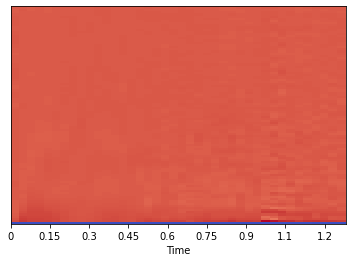

In [ ]:
# '그609' 음성의 mfcc를 시각화 한 것. '음, 그, 아'에 따라 그림이 다르게 나온다!
import librosa.display
librosa.display.specshow(padded_mfcc, sr=16000, x_axis='time')

# Ready for Data

In [ ]:
# 오디오 데이터 주소
%cd /content/drive/MyDrive/SpeakUP_ML
DATA_DIR = './dataset'

/content/drive/MyDrive/SpeakUP_ML


## 전체 파일에 대해 해보기

In [ ]:
# train과 test의 mfcc를 담는 공간
trainset = []
testset = []

# split each set into raw data, mfcc data, and y data
# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것
train_X = []
train_mfccs = []
train_y = []

test_X = []
test_mfccs = []
test_y = []

frame_length = 0.025
frame_stride = 0.0010

In [ ]:
# train data를 넣는다.
for filename in os.listdir(DATA_DIR + "/train/"):
    # 파일 이름이 한국어라서 오류 안생기게 인코딩 해주기 
  filename = normalize('NFC', filename)
  try:
    # wav 포맷 데이터만 사용
    if '.wav' not in filename in filename:
      continue

    #음성파일 별로 샘플링  
    wav, sr = librosa.load(DATA_DIR+ "/train/"+ filename, sr=16000)
    # 음성파일 별로 mfcc 뽑아오기
    mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
    # mfcc 값 스케일링
    mfcc = scaler.fit_transform(mfcc)
    # mfcc padding
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새가 아닌 경우 1, 추임새인 경우 0
    # 즉 trainset의 차원은 (100,40,1)
    if filename[0] == '외':
      trainset.append((padded_mfcc, 1))
    else:
      trainset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

# 학습 데이터를 무작위로 섞는다.
random.shuffle(trainset)

In [ ]:
# test data를 넣는다.
for filename in os.listdir(DATA_DIR + "/test/"):
  filename = normalize('NFC', filename)
  try:
    # wav 포맷 데이터만 사용
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR+ "/test/"+ filename, sr=16000)
    
    mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
    mfcc = scaler.fit_transform(mfcc)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새가 아닌 경우 1, 추임새인 경우 0
    # 즉 testset의 차원은 (100,40,1)
    if filename[0] == '외':
      testset.append((padded_mfcc, 1))
    else:
      testset.append((padded_mfcc, 0))
  except Exception as e:
    print(filename, e)
    raise

# 평가 데이터를 무작위로 섞는다.
random.shuffle(testset)

In [ ]:
import pandas as pd
train_list=pd.DataFrame(trainset)
train_list

,0,1
0,"[[-9.736085891723633, -9.509709358215332, -9.4...",1
1,"[[-9.805315971374512, -9.82199764251709, -9.83...",1
2,"[[-9.877345, -9.784827, -9.712656, -9.62476, -...",1
3,"[[-9.813488, -9.835431, -9.812493, -9.782524, ...",1
4,"[[-9.642184, -9.425559, -9.400332, -9.191782, ...",0
...,...,...
3140,"[[-9.794712, -9.730878, -9.846659, -9.796601, ...",0
3141,"[[-9.444794, -9.042891, -9.042786, -9.062469, ...",0
3142,"[[-8.766137, -8.505661, -8.39907, -8.291757, -...",0
3143,"[[-9.541857719421387, -9.508482933044434, -9.5...",1


In [ ]:
train_array=np.array(trainset)
train_array.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(3145, 2)

In [ ]:
test_array=np.array(testset)
test_array.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(200, 2)

In [ ]:
# 3145개 mfcc값만
train_mfccs = [a for (a,b) in trainset]
# 답
train_y = [b for (a,b) in trainset]

# 200개 mfcc값만
test_mfccs = [a for (a,b) in testset]
# 답
test_y = [b for (a,b) in testset]

train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (3145, 100, 40)
train_y: (3145, 2)
test_mfccs: (200, 100, 40)
test_y: (200, 2)


In [ ]:
# 3145는 데이터 갯수
# 100은 1개의 window당 mfcc값
# 40은 데이터 길이 통일하려고 40으로 자른것

# MFCC feature로 학습

In [ ]:
# 3차원으로 만들어서 conv 2D 쓴다
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (3145, 100, 40, 1)
test X shape: (200, 100, 40, 1)


In [ ]:
# (100,40,1)
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(2, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 40, 1)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 37, 96)        1632      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 9, 96)         0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1327168   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66    

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
99/99 [==============================] - 19s 8ms/step - loss: 0.4473 - accuracy: 0.7994 - val_loss: 0.2243 - val_accuracy: 0.9250
Epoch 2/100
99/99 [==============================] - 1s 6ms/step - loss: 0.2292 - accuracy: 0.9132 - val_loss: 0.2686 - val_accuracy: 0.8800
Epoch 3/100
99/99 [==============================] - 1s 6ms/step - loss: 0.1861 - accuracy: 0.9243 - val_loss: 0.5006 - val_accuracy: 0.8000
Epoch 4/100
99/99 [==============================] - 1s 7ms/step - loss: 0.1378 - accuracy: 0.9529 - val_loss: 0.2788 - val_accuracy: 0.8800
Epoch 5/100
99/99 [==============================] - 1s 6ms/step - loss: 0.1330 - accuracy: 0.9523 - val_loss: 0.3049 - val_accuracy: 0.8750
Epoch 6/100
99/99 [==============================] - 1s 6ms/step - loss: 0.0939 - accuracy: 0.9657 - val_loss: 0.1706 - val_accuracy: 0.9350
Epoch 7/100
99/99 [==============================] - 1s 7ms/step - loss: 0.0784 - accuracy: 0.9733 - val_loss: 0.2746 - val_accuracy: 0.9100
Epoch 8/100


In [ ]:
model.save('./isfiller_classifier_0928.h5')

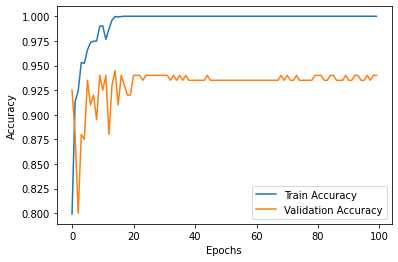

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## 하나만 넣어서 테스트 해보기

In [ ]:
wav, sr = librosa.load('./dataset/train/그603.wav', sr=16000)
mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = scaler.fit_transform(mfcc)
padded_mfcc = pad2d(mfcc, 40)

In [ ]:
padded_mfcc = np.expand_dims(padded_mfcc, -1)

In [ ]:
padded_mfcc = np.expand_dims(padded_mfcc, 0)

In [ ]:
padded_mfcc.shape

(1, 100, 40, 1)

In [ ]:
from keras.models import load_model

In [ ]:
filler_classifier_model = load_model('./isfiller_classifier_0928.h5')

In [ ]:
filler_classifier_model.predict(padded_mfcc)

array([[1.0000000e+00, 1.0166389e-12]], dtype=float32)

In [ ]:
# 얘는 class 0, 추임새이다!!!!!!